# Project group 30

# What is the correlation between a country's corruption perception index and their likelihood of being awarded a medal during the Olympic Games?

In [72]:
#read necessary libraries 
import numpy as np
import pandas as pd
import pycountry
import pycountry_convert as pcc
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
pd.options.display.max_rows = 20
np.set_printoptions(precision = 4, suppress = True)
#ignore SettingWithCopyWarning: this is a known issue with pandas
pd.options.mode.chained_assignment = None

Necesarry installations:

In [73]:
#pip install pycountry_convert
#pip install fuzzywuzzy

In [74]:
#loading the csv files into dataframes
population = 'population.csv'
df_population= pd.read_csv(population)
medals = 'medals.csv'
df_medals= pd.read_csv(medals)
cpi = 'cpi.csv'
df_cpi= pd.read_csv(cpi)
df_happiness = pd.read_csv('world-happiness-report-2021.csv')
df_population_density = pd.read_csv('population_by_country_2020.csv')
df_drinking = pd.read_csv('drinks.csv')
factors_of_interest = []

In [75]:

def normalize_countries(dataframe, name_country_column):

    # Create a list of all unique countries in the dataframe

    countries = dataframe[name_country_column].unique().tolist()

    #Create a list of all standard country names
    countries_standard = [country.name for country in pycountry.countries]

    for i in range(len(dataframe)):
        temp = dataframe[name_country_column][i]
        country = 'c'
        try:
            country = pycountry.countries.lookup(temp)
        except LookupError as e:
            pass
        if country == 'c':
            try:
                match = process.extractOne(str(temp), countries_standard, scorer=fuzz.token_sort_ratio)
                if match[1] > 74:
                    c = pycountry.countries.get(name=match[0])
                    country_code=c.alpha_3
                    dataframe.loc[i, name_country_column] = country_code
                else:
                    dataframe.loc[i, name_country_column] = None
            except ValueError as e:
                dataframe.loc[i, name_country_column] = None
        else:
            dataframe.loc[i, name_country_column] = country.alpha_3


In [76]:
normalize_countries(df_medals, 'Country')

#manually converting few instances
#Kosovo doesn't have ISO3
df_medals.at[3, 'Country'] = 'GBR'
df_medals.at[4, 'Country'] = 'RUS'
df_medals.at[33, 'Country'] = 'TWN'


Display the original table with "Gold Medal", "Silver Medal" and "Bronze Medal" columns:

In [77]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
   print(df_medals)

   Country  Gold Medal  Silver Medal  Bronze Medal  Total  Rank By Total
0      USA          39            41            33    113              1
1      CHN          38            32            18     88              2
2      JPN          27            14            17     58              5
3      GBR          22            21            22     65              4
4      RUS          20            28            23     71              3
5      AUS          17             7            22     46              6
6      NLD          10            12            14     36              9
7      FRA          10            12            11     33             10
8      DEU          10            11            16     37              8
9      ITA          10            10            20     40              7
10     CAN           7             6            11     24             11
11     BRA           7             6             8     21             12
12     NZL           7             6             7 

# Methodology

Medals scoring system:
    
    GOLD - 3 points
    SILVER - 2 points
    BRONZE - 1 point


In [78]:
#calculating the value of the medals earned
medal_values=[]
for i in range(len(df_medals)):
    temp_g=df_medals['Gold Medal'][i]
    #print(temp_g)
    temp_s=df_medals['Silver Medal'][i]
    temp_b=df_medals['Bronze Medal'][i]
    value=(temp_g*3)+(temp_s*2)+temp_b
    medal_values.append(value)
df_medals["Medal Value"] = medal_values

In [79]:
#merging medal df with population df
df_merged1 = pd.merge(df_medals, df_population, left_on='Country', right_on='CCA3')

#calculation medal value per million inhabitants
medals_per_million=[]
for i in range(len(df_merged1)):
    medal_adjusted = df_merged1['Medal Value'][i]/(df_merged1['2020 Population'][i]/1000000) 
    medals_per_million.append(medal_adjusted)
df_merged1["Medals per million"] = medals_per_million

#merging the resulting df with cpi df
df_merged2 = pd.merge(df_merged1, df_cpi, left_on='Country', right_on='ISO3', how='left')
df_merged2
df = df_merged2[['Country_x','Medal Value', 'Medals per million','2020 Population', 'CPI score 2019']]

factors_of_interest += ['CPI score 2019']
df

,Country_x,Medal Value,Medals per million,2020 Population,CPI score 2019
0,USA,232,0.690595,335942003,69.0
1,CHN,196,0.137551,1424929781,41.0
2,JPN,126,1.006030,125244761,73.0
3,GBR,130,1.938578,67059474,77.0
4,RUS,139,0.954557,145617329,28.0
...,...,...,...,...,...
87,GHA,1,0.031075,32180401,41.0
88,GRD,1,8.086493,123663,53.0
89,KWT,1,0.229334,4360444,40.0
90,MDA,1,0.324165,3084847,32.0


Merging dataframe with Alcohol Consumption

In [80]:
#preparing data
normalize_countries(df_drinking, 'country')
df_drinking = df_drinking[['country', 'total_litres_of_pure_alcohol']]
df_drinking.rename(columns = {'total_litres_of_pure_alcohol':'Alcohol Consumed (L/P/Y)'}, inplace = True)

#merging
df = pd.merge(df, df_drinking, left_on='Country_x', right_on='country', how='left')
df = df.drop(columns=['country'])

factors_of_interest += ['Alcohol Consumed (L/P/Y)']


Adding happiness levels to the dataframe

In [81]:
#preparing the dataframe
df_happiness.rename(columns = {'Ladder score':'Happiness score'}, inplace = True)
df_happiness = df_happiness[['Country name', 'Happiness score']]
normalize_countries(df_happiness, 'Country name')


#manually converting some names
df_happiness.at[75, 'Country name'] = 'RUS'
df_happiness.at[117, 'Country name'] = 'IRN'
df_happiness.at[76, 'Country name'] = 'HKG'
df_happiness.at[84, 'Country name'] = 'CIV'

#merging
df = pd.merge(df, df_happiness, left_on='Country_x', right_on='Country name', how='left')
df = df.drop(columns=['Country name'])

factors_of_interest += ['Happiness score']


Adding population density to the dataframe

In [82]:
#preparing dataframe
df_population_density.rename(columns = {'Country (or dependency)':'Countries'}, inplace = True)
df_population_density.rename(columns = {'Density (P/Km²)':'Population Density (P/Km²)'}, inplace = True)

df_population_density = df_population_density[['Countries', 'Population Density (P/Km²)', 'Med. Age', 'Urban Pop %']]



#manually converting some data to required format
df_population_density.at[8, 'Countries'] = 'RUS'
df_population_density.at[85, 'Countries'] = 'CZE'
df_population_density.at[17, 'Countries'] = 'IRN'
df_population_density.at[67, 'Countries'] = 'SYR'



normalize_countries(df_population_density, 'Countries')

#merging
df = pd.merge(df, df_population_density, left_on='Country_x', right_on='Countries', how='left')
df = df.drop(columns=['Countries'])

#stripping and converting data for use
df.replace(' %', '', regex=True, inplace=True)
df = df[df['Urban Pop %']!= 'N.A.']
df = df[df['Med. Age']!= 'N.A.']
df = df.astype({'Med. Age':'int'})
df = df.astype({'Urban Pop %':'int'})
factors_of_interest += ['Population Density (P/Km²)', 'Med. Age', 'Urban Pop %']


Display a modified table with the weighted values of medals:

In [83]:


display(df)
print(factors_of_interest)

,Country_x,Medal Value,Medals per million,2020 Population,CPI score 2019,Alcohol Consumed (L/P/Y),Happiness score,Population Density (P/Km²),Med. Age,Urban Pop %
0,USA,232,0.690595,335942003,69.0,8.7,6.951,36,38,83
1,CHN,196,0.137551,1424929781,41.0,5.0,5.339,153,38,61
2,JPN,126,1.006030,125244761,73.0,7.0,5.940,347,48,92
3,GBR,130,1.938578,67059474,77.0,10.4,7.064,281,40,83
4,RUS,139,0.954557,145617329,28.0,11.5,5.477,9,40,74
...,...,...,...,...,...,...,...,...,...,...
87,CIV,1,0.037297,26811790,35.0,4.0,5.306,83,19,51
88,GHA,1,0.031075,32180401,41.0,1.8,5.088,137,22,57
89,GRD,1,8.086493,123663,53.0,11.9,NaN,331,32,35
91,MDA,1,0.324165,3084847,32.0,6.3,5.766,123,38,43


['CPI score 2019', 'Alcohol Consumed (L/P/Y)', 'Happiness score', 'Population Density (P/Km²)', 'Med. Age', 'Urban Pop %']


# Visualizations

<class 'numpy.int64'>


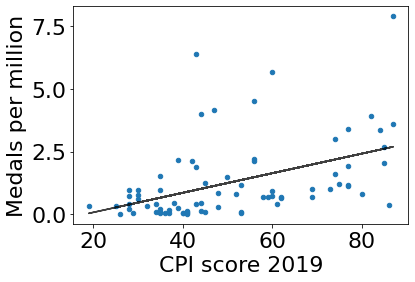

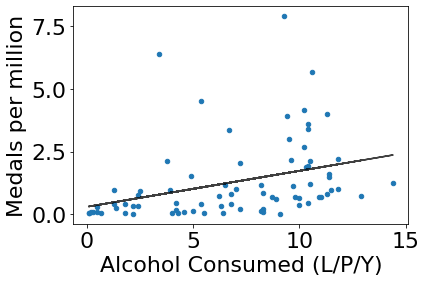

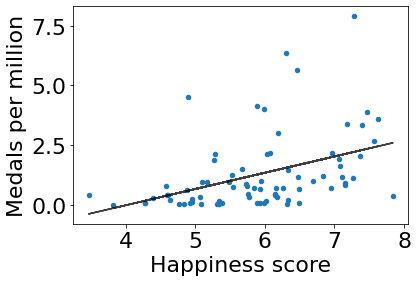

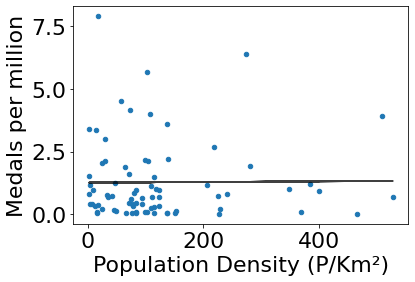

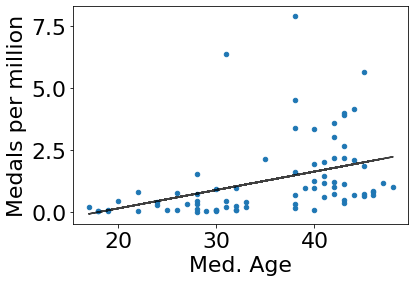

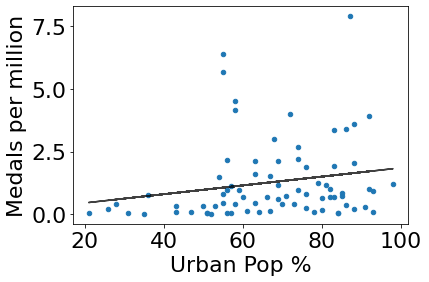

In [84]:

df_no_outliers = df[df['Medals per million']<12].dropna()
df_no_outliers = df[df['Population Density (P/Km²)']<1000].dropna()
plt.rcParams.update({'font.size': 22})

#function to make a scatterplot with a trend line
def scatterplot(df, x_data, y_data):

    df.plot.scatter(x=x_data,y=y_data)
    z = np.polyfit(df[x_data], df[y_data], 1)
    p = np.poly1d(z) 
    plt.plot(df[x_data],p(df[x_data]), 'k', alpha=0.75)
print(type(df['Population Density (P/Km²)'][1]))

for factor in factors_of_interest:
   scatterplot(df_no_outliers, factor, 'Medals per million')




In [85]:
df.corr(method ='pearson')['Medals per million']

Medal Value                   0.000368
Medals per million            1.000000
2020 Population              -0.182275
CPI score 2019                0.373563
Alcohol Consumed (L/P/Y)      0.228887
Happiness score               0.422423
Population Density (P/Km²)   -0.006843
Med. Age                      0.218638
Urban Pop %                   0.135155
Name: Medals per million, dtype: float64

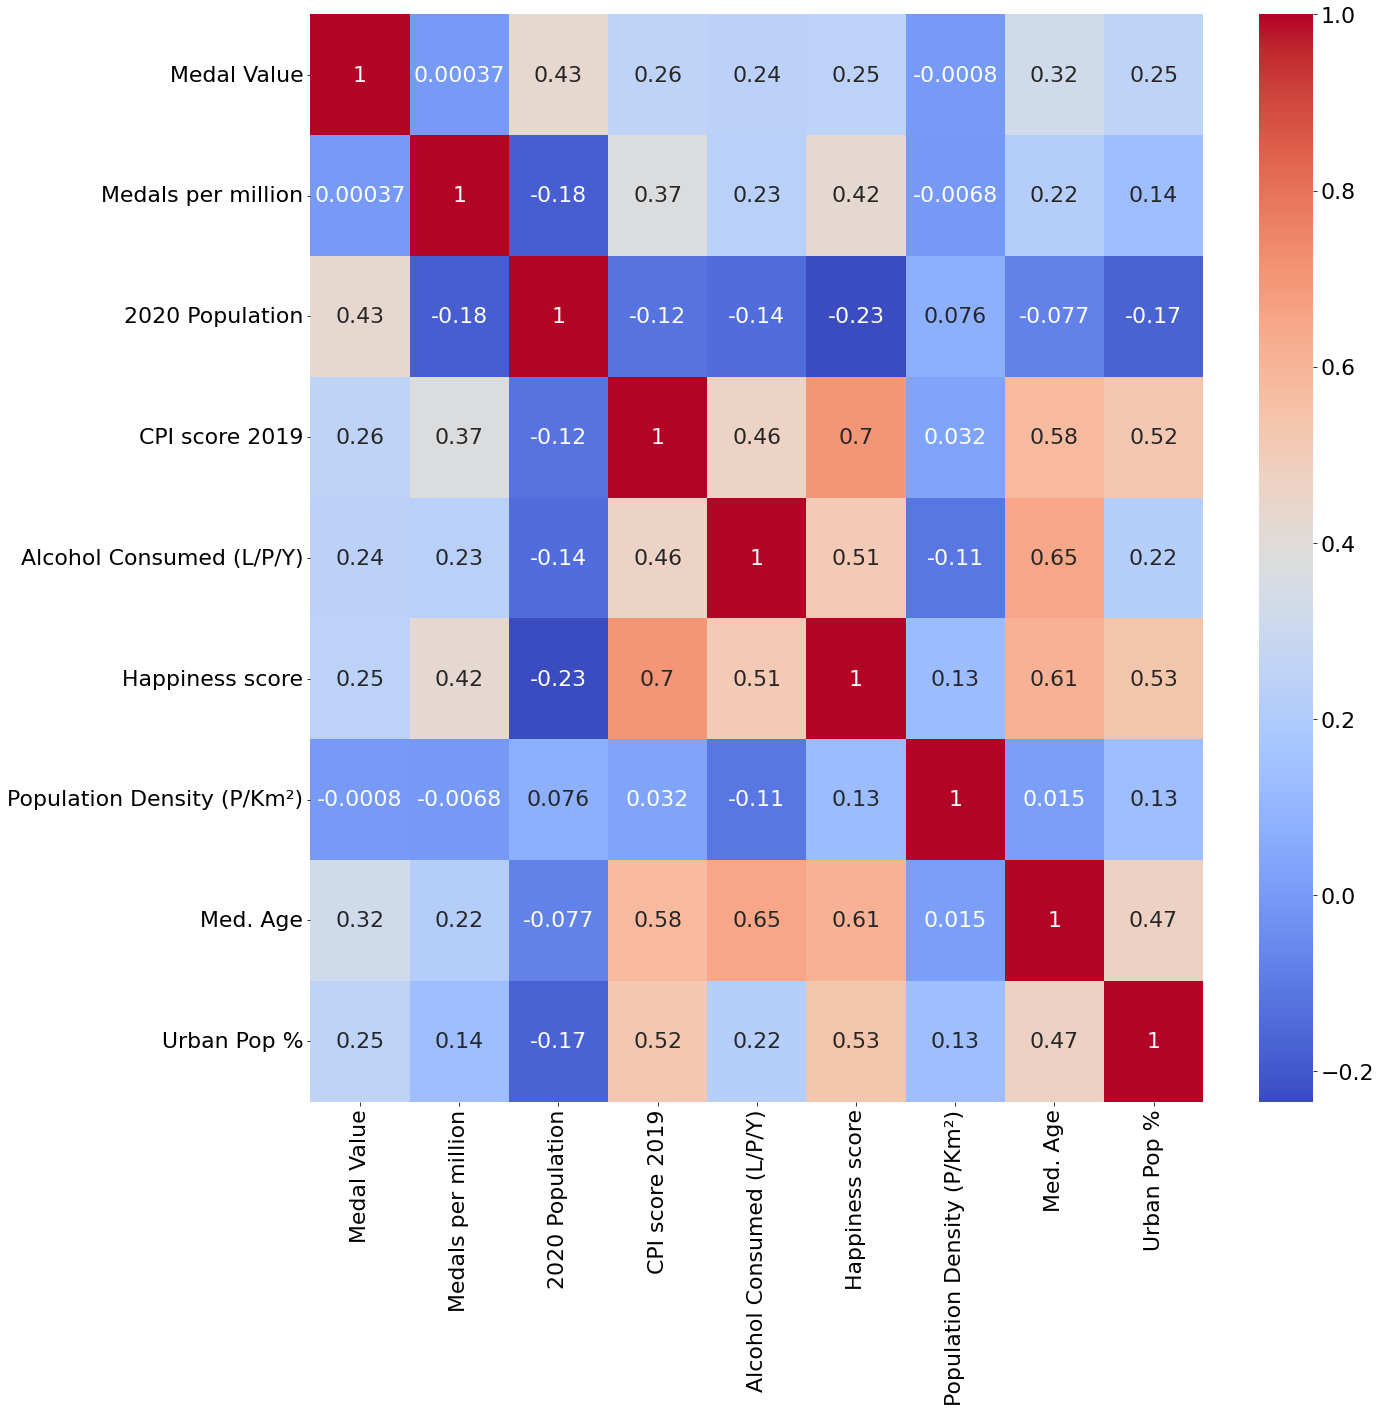

In [86]:
import seaborn as sns

# visualizing the correlation matrix of the selected factors
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [87]:

new_df = df_no_outliers[['Country_x', 'Medal Value', 'Medals per million']]
new_df



import plotly.express as px




fig = px.choropleth(new_df, locations="Country_x",
                    color="Medals per million", 
                    hover_name="Country_x", 
                    color_continuous_scale=px.colors.sequential.Plasma)


fig.update_layout(
    title_text = 'Medals per million',
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular',
    ),
    width=800,
    height=400,   
    autosize=False,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0
    ),

)
fig.show()





In [88]:
import plotly.express as px


fig = px.scatter_geo(new_df, locations="Country_x",
                        color="Medal Value", 
                        hover_name="Country_x", 
                        size="Medal Value",
                        projection="natural earth",
                        color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(
    title_text = 'Medal Value',
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular',
    ),
    width=800,
    height=400,
    autosize=False,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0

    ),

)
fig.show()

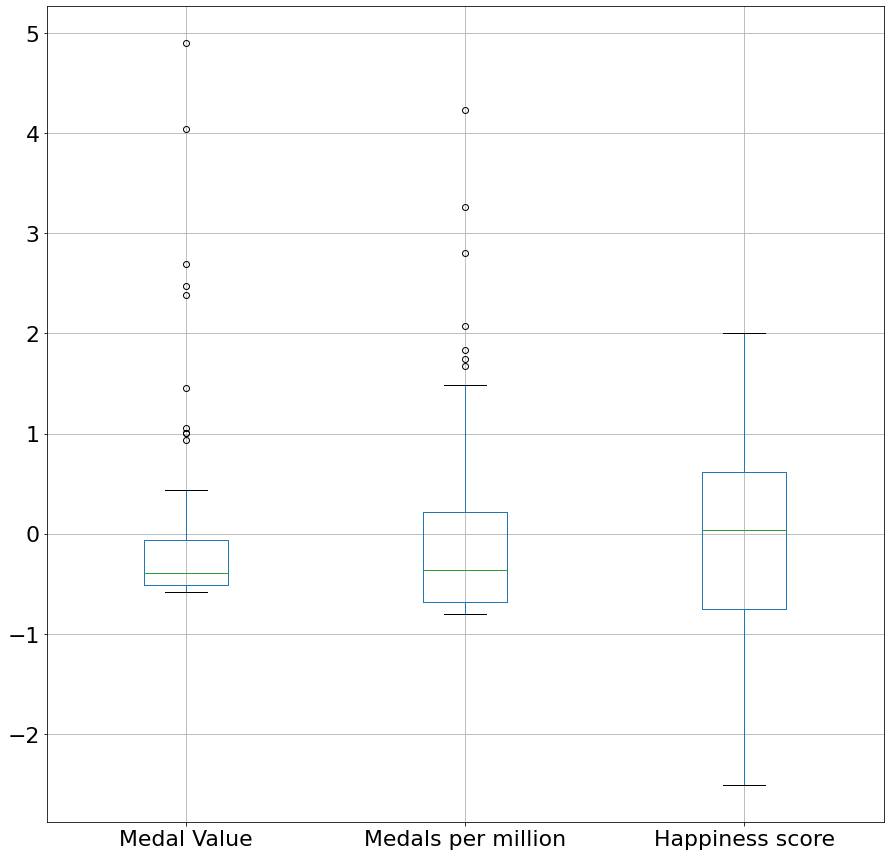

In [90]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# create a new dataframe with the standardized data
new_df = df_no_outliers[['Country_x', 'Medal Value', 'Medals per million', 'Happiness score']]


# standardize the data
new_df['Medal Value'] = scaler.fit_transform(new_df[['Medal Value']])
new_df['Medals per million'] = scaler.fit_transform(new_df[['Medals per million']])
new_df['Happiness score'] = scaler.fit_transform(new_df[['Happiness score']])


new_df.boxplot(column=['Medal Value', 'Medals per million', 'Happiness score'], figsize=(15,15))
plt.show()